<h1>MLTS Exercise 02 - Bayesian Linear Regression</h1>

### Task:

This notebook provides three time series datasets, each representing daily user counts for separate applications over the year 2020:
* `App_1_Users_2020.csv`
* `App_2_Users_2020.csv`
* `App_3_Users_2020.csv`

In the previous exercise, you already took a look at the datasets and did some basic visual analysis.

In this exercise, you will use Bayesian Linear Regression to analyse the datasets further and to get to know the method more in-depth. Additionally, you will use the method to do a simple forcasting on the time series.

For each dataset, complete the following tasks:

* Set up a Bayesian Linear Regression Model with PyMC on the train set and choose informative priors.
* Check if the prior is choosen well and the model can actually predict the observed train set.
* Draw samples for the posterior distribution to find the best parameters for the model.
* Check if the sampled posterior can predict the observed train data.
* Test if the model also works on the test set.


In [1]:
# import packages
%matplotlib widget
import os
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Helper variables and functions
RANDOM_SEED = 42

def plot_xY(x, Y, ax):
    """This fuction plots the prediction

    Args:
        x: The date of the time series (train.index)
        Y: The prediction by the model
        ax: The matplotlib axis
    """
    quantiles = Y.quantile((0.025, 0.25, 0.5, 0.75, 0.975), dim=("chain", "draw")).transpose()

    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.025, 0.975]),
        fill_kwargs={"alpha": 0.25},
        smooth=False,
        ax=ax,
    )
    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.25, 0.75]),
        fill_kwargs={"alpha": 0.5},
        smooth=False,
        ax=ax,
    )
    ax.plot(x, quantiles.sel(quantile=0.5), color="C1", lw=3)

Load the dataset

In [3]:
# paths to data
base_path = '../00_Datasets/01-03_App_Datasets'
path = 'App_1_Users_2020.csv'
# path = 'App_2_Users_2020.csv'
# path = 'App_3_Users_2020.csv'

path = os.path.join(base_path, path)

In [4]:
# Read data from file
data = pd.read_csv(path, sep=';', index_col='date')
data.index = pd.to_datetime(data.index)
data.head()

,time,users
date,,
2020-01-01,0,499
2020-01-02,1,501
2020-01-03,2,500
2020-01-04,3,500
2020-01-05,4,501


Split the data into training and test sets, with the test set comprising the final three months of 2020.

In [5]:
# Split into train and test set
split_time = '2020-10-01'
train = data[data.index < split_time]
test = data[data.index >= split_time]

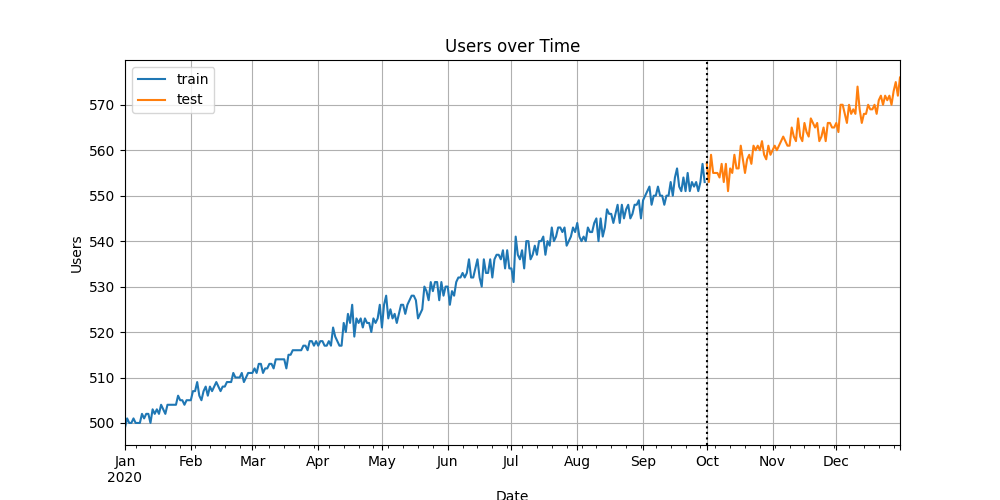

In [6]:
# Plot train and test set
fig, ax = plt.subplots(figsize=(10, 5))
ax = train["users"].plot(label='train')
test["users"].plot(label='test')
ax.axvline(split_time, c="k", ls=":")
ax.set_xlabel('Date')
ax.set_ylabel('Users')
ax.grid()
ax.set_title('Users over Time')

plt.legend()
plt.show()

## Modelling

Let us build a Bayesian Linear Regression Model

In [23]:
# TODO: create and setup a PyMC model
from pymc import Model, HalfCauchy, Normal, sample

with Model() as model:
    # define priors
    # variance
    sigma = HalfCauchy('sigma', beta=10)
    # bias
    intercept = Normal('intercept', mu=0, sigma=10)
    slope = Normal('slope', mu=0, sigma=10)
    
    # define likelihood
    likelihood = Normal('y', mu=intercept + slope * train.time, sigma=sigma, observed=train['users'])
    


## Check the prior

As part of the Bayesian workflow, we will plot our prior predictions to see what outcomes the model finds before having observed any data. Is the prior chosen well?

Sampling: [intercept, sigma, slope, y]


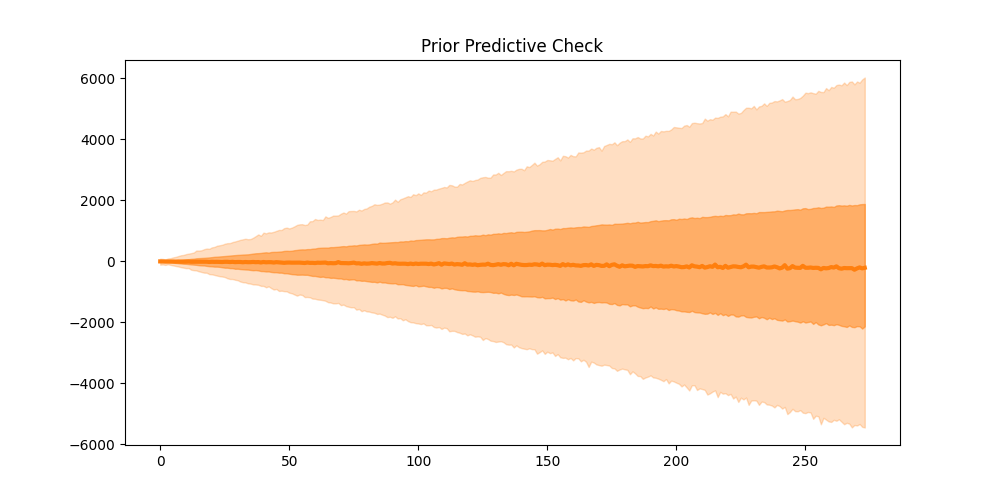

In [30]:
# Get the prior
with model:
    prior_predictive = pm.sample_prior_predictive()

# Plot the prior prediction
fig, ax = plt.subplots(figsize=(10, 5))
plot_xY(train.time, prior_predictive.prior_predictive["y"], ax)
ax.set_title("Prior Predictive Check")
plt.show()

## "Train" the model

Draw samples for the posterior distribution on the train set and find the best parameters for the model.

In [19]:
with model:
    # inference
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, slope]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 8 seconds.


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

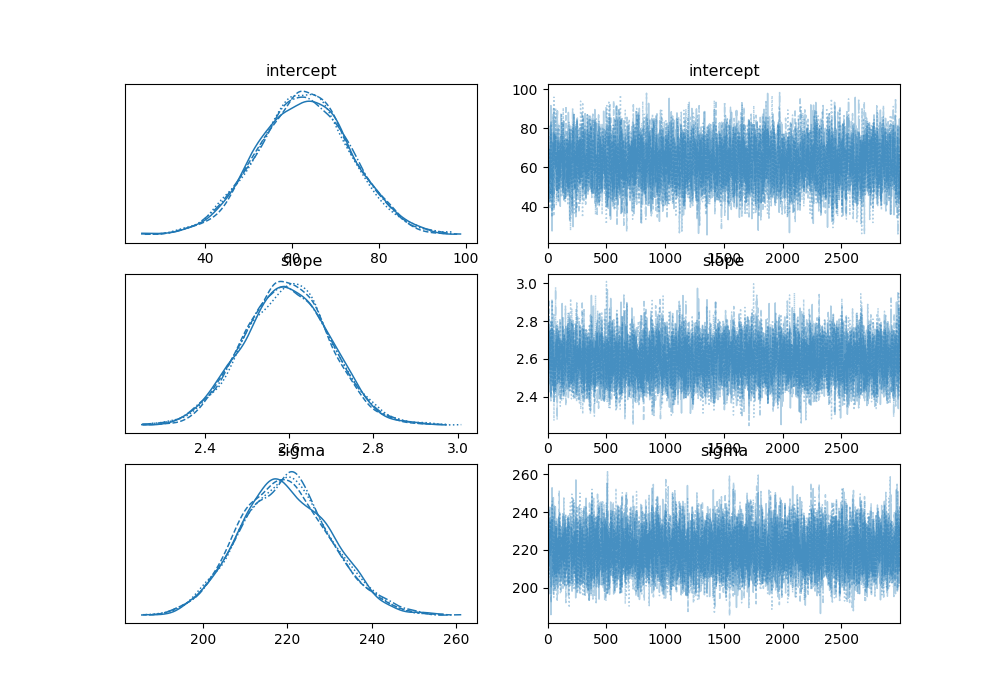

In [20]:
az.plot_trace(idata, figsize=(10,7))

## Posterior predictive check

Another important aspect of the Bayesian workflow is to plot the model's posterior predictions, allowing us to see how well the model can predict the observed train data.

Sampling: [y]


Output()

<Axes: xlabel='y'>

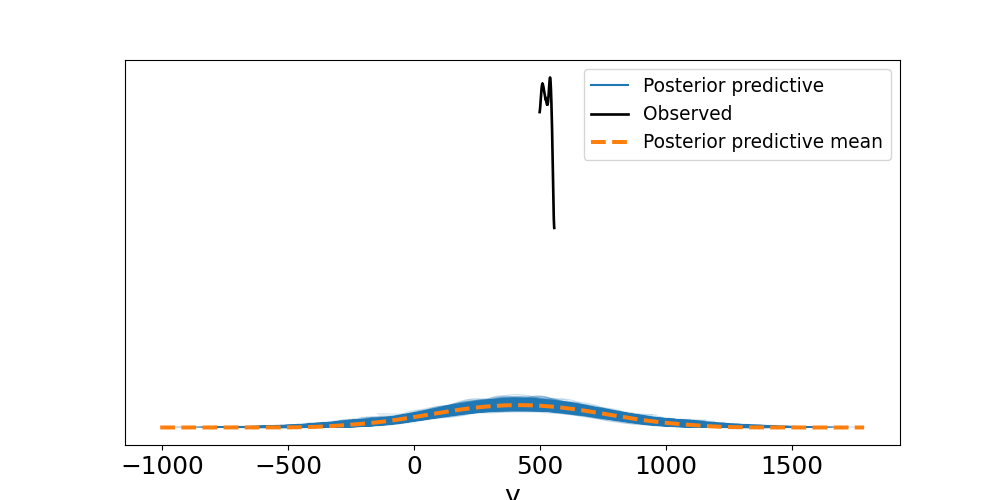

In [ ]:
with model:
    # Posterior predictive check
    ppc = pm.sample_posterior_predictive(idata, extend_inferencedata=True)
    


<Axes: xlabel='y'>

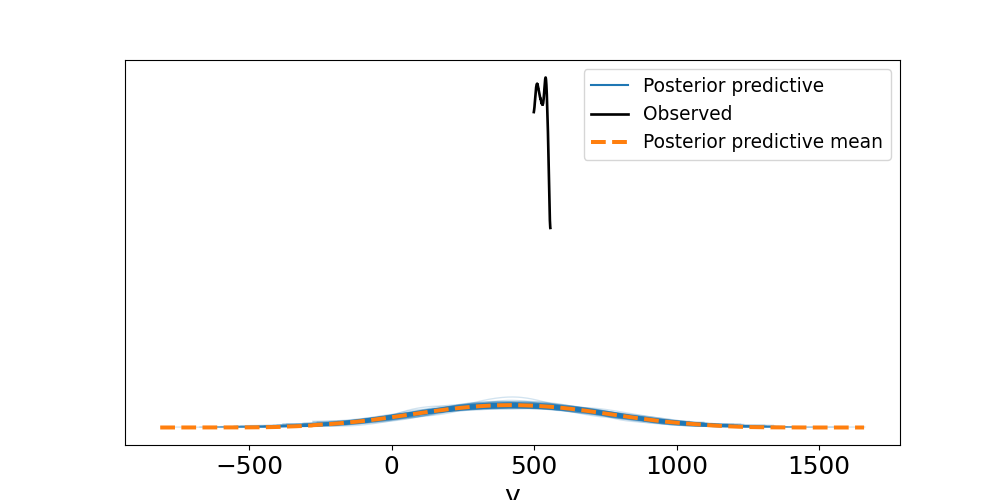

In [48]:
az.plot_ppc(idata, figsize=(10, 5), num_pp_samples=100)

## Inference on test set

Now we will use our model to predict/forcast the expected number of users for the last 3 months of the year (test set).

In [53]:
test.time

date
2020-10-01    274
2020-10-02    275
2020-10-03    276
2020-10-04    277
2020-10-05    278
             ... 
2020-12-27    361
2020-12-28    362
2020-12-29    363
2020-12-30    364
2020-12-31    365
Name: time, Length: 92, dtype: int64

In [54]:
# TODO: set test data and predict its posterior from the model
with model:
    # Set new data
    pm.set_data({"x": test.time})
    # Predict the posterior
    posterior_predictive_test = pm.sample_posterior_predictive(idata)

KeyError: 'x'

In [13]:
# TODO: plot the posterior on the test set


In [14]:
# TODO: Plot train and test set with prediction
